In [4]:
%pip install -Uqq fastai

Note: you may need to restart the kernel to use updated packages.


In [5]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url, data = {'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(), {'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [6]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://1.bp.blogspot.com/-HVQCgDX3tY8/VHQz32tGwCI/AAAAAAAACDQ/gDoTznnkYTU/s1600/top_10_most_beautiful_amazing_birds_in_the_world_Atlantic-Puffin.jpg'

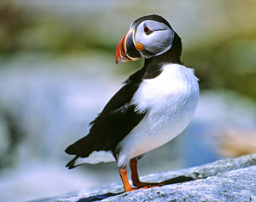

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)